In [1]:
# Import libraries
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# 1. Load and clean
df = pd.read_csv("./datasets/uber.csv")
df.dropna(inplace=True)
df = df[df.fare_amount > 0]

In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
# 2. Feature engineering – distance using haversine
def dist(lat1, lon1, lat2, lon2):
    r = 6371
    a = np.radians(lat2 - lat1)
    b = np.radians(lon2 - lon1)
    c = np.sin(a/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(b/2)**2
    return 2*r*np.arcsin(np.sqrt(c))
df["distance"] = dist(df.pickup_latitude, df.pickup_longitude,
                      df.dropoff_latitude, df.dropoff_longitude)

In [12]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475450


In [6]:
# 3. Remove outliers (IQR)
q1, q3 = df.fare_amount.quantile([0.25,0.75])
iqr = q3 - q1
df = df[(df.fare_amount > q1 - 1.5*iqr) & (df.fare_amount < q3 + 1.5*iqr)]

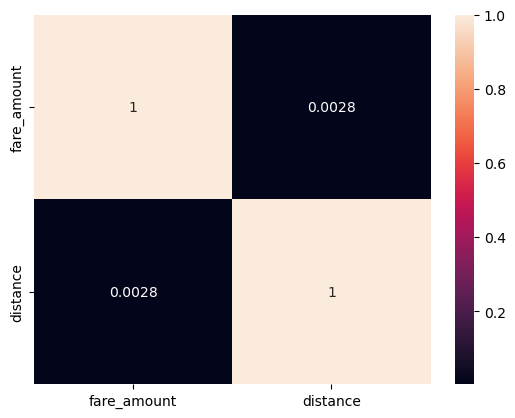

In [7]:
# 4. Correlation
sns.heatmap(df[["fare_amount","distance"]].corr(), annot=True)
plt.show()

In [8]:
# 5. Split data
X = df[["distance"]]
y = df["fare_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [9]:
# 6. Scale (important for Ridge & Lasso)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# 7. Train models
lr = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=1).fit(X_train, y_train)
lasso = Lasso(alpha=0.1).fit(X_train, y_train)

In [11]:
# 8. Evaluate
def score(model):
    pred = model.predict(X_test)
    print(model.__class__.__name__,
          "R2:", round(r2_score(y_test, pred),3),
          "RMSE:", round(np.sqrt(mean_squared_error(y_test, pred)),3))

score(lr); score(ridge); score(lasso)

LinearRegression R2: 0.0 RMSE: 4.145
Ridge R2: 0.0 RMSE: 4.145
Lasso R2: -0.0 RMSE: 4.145
